<a href="https://colab.research.google.com/github/cutlersimpson/GU-ML/blob/main/ML_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Differentially Expressed Genes in Liver Hepatocellular Carcinoma (LIHC)
October 10, 2022

---
<br>

The goal of this report is to explore a dataset from The Cancer Genome Atlas (TCGA) to identify significantly up and down regulated genes in liver hepatocellular carcinoma (LIHC). The dataset contains both tumor and non-tumor samples which are further grouped into LIHC and BRCA buckets. Identifying genes that are differentially expressed in LIHC can help with cancer diagnosis and treatment prediction, therefore BRCA samples are to be filtered out during the exploratory analysis steps.


In [49]:
#@markdown Install imports necessary for analysis
#imports
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
from matplotlib.colors import LogNorm

In [30]:
#@markdown Load data from The Cancer Genome Atlas (TCGA), 
#@markdown preprocess the data, and view first 5 rows
#load data and view the first 5 rows
GeneExpression1 = pd.read_table('https://raw.githubusercontent.com/PineBiotech/omicslogic/master/LIHC_BRCA_data1_marked.txt', header=None)

#set the column names and row names
GeneExpression1.columns = GeneExpression1.iloc[0]
GeneExpression1.index = GeneExpression1.Id

#remove duplicate ID row and column
GeneExpression1 = GeneExpression1.drop(index='Id')
GeneExpression1 = GeneExpression1.drop(['Id'], axis = 1) 

#change gene names to not include the problematic | sign
GeneExpression1.index=GeneExpression1.index.str.replace('|','_')

#fix the problematic "class" label
GeneExpression1 = GeneExpression1.rename(index={'class':'Group'})

#transpose the data frame
GeneExpression1 = GeneExpression1.transpose()

#make sure the data is numeric
GeneExpression1 = GeneExpression1.apply(pd.to_numeric, errors="ignore")

GeneExpression1.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  from ipykernel import kernelapp as app


Id,Group,a100130426,a100133144,a100134869,a10357,a10431,a136542,a155060,a26823,a280660,...,ZXDA_7789,ZXDB_158586,ZXDC_79364,ZYG11A_440590,ZYG11B_79699,ZYX_7791,ZZEF1_23140,ZZZ3_26009,psiTPTE22_387590,tAKR_389932
0,,,,,,,,,,,,,,,,,,,,,
TCGA-2V-A95S-01A-11R-A37K-07_LIHC_TP,LIHC_TP,0.0,2.31,5.69,138.30,1561.0,0,217.0,1.0,0,...,38.0,420.0,1219.0,28.0,766.0,4869.0,1366.0,783.0,6.0,10.0
TCGA-2Y-A9GS-01A-12R-A38B-07_LIHC_TP,LIHC_TP,0.0,53.59,5.41,144.07,1297.0,0,249.0,3.0,0,...,139.0,1284.0,2341.0,145.0,2030.0,10756.0,1533.0,1746.0,13.0,980.0
TCGA-2Y-A9GU-01A-11R-A38B-07_LIHC_TP,LIHC_TP,0.0,6.86,6.14,73.93,1423.0,0,336.0,1.0,0,...,22.0,342.0,1379.0,11.0,1129.0,3708.0,1606.0,412.0,3.0,3.0
TCGA-BC-A10Q-11A-11R-A131-07_LIHC_NT,LIHC_NT,0.0,2.00,0.00,103.92,1454.0,0,32.0,0.0,0,...,42.0,675.0,679.0,67.0,1942.0,2799.0,493.0,486.0,14.0,167.0
TCGA-BC-A10T-11A-11R-A131-07_LIHC_NT,LIHC_NT,0.0,1.41,2.59,96.89,1125.0,0,7.0,0.0,0,...,24.0,522.0,863.0,8.0,947.0,1661.0,320.0,694.0,2.0,68.0


The initial data pull contains 20,532 columns of gene expression data as shown above. Because of this, the data will be interrogated by determining the p-values and log fold change values relative to tumor and non tumor groups which will be used to identify the most significant differentially expressed genes. Once these genes have been identified, various visualization tools including a heat map and scatter plot can be used to demonstrate this significance.


In [31]:
#@markdown Generate p-values and fold change values for LIHC-NT and LIHC_TP groups to identify significantly up or downregulated genes
# Generate a list of p-values and logFc for each gene
p_vals=['p-value']
logFC=['logFC']

for i in range(1,len(GeneExpression1.columns)):
  p_vals.append(stats.ttest_ind(GeneExpression1.iloc[:,i][GeneExpression1['Group'] == 'LIHC_NT'], GeneExpression1.iloc[:,i][GeneExpression1['Group'] == 'LIHC_TP'])[1])
  logFC.append(np.log((GeneExpression1.iloc[:,i][GeneExpression1['Group'] == 'LIHC_NT'].mean()+1) / (GeneExpression1.iloc[:,i][GeneExpression1['Group'] == 'LIHC_TP'].mean()+1)))

#append the p_values and logFC to the main table
p_vals1 = pd.Series(p_vals, index = GeneExpression1.columns)
logFC1 = pd.Series(logFC, index = GeneExpression1.columns)

GeneExpression1 = GeneExpression1.append(p_vals1, ignore_index=True)
GeneExpression1 = GeneExpression1.append(logFC1, ignore_index=True)

In [47]:
#@markdown Filter data down to significantly up or downregulated genes only and display first 5 rows sorted by logFC

#clean up extra columns and only use LIHC columns
geneT = GeneExpression1.transpose()
geneT = geneT.rename(index={'Group':'Id'})
geneT.columns = geneT.loc['Id']
geneT = geneT.drop(['Id'], axis = 0)

#Keep only genes with p-value less then 0.05 and logFC > 1.5 or less than -1.5
geneT = geneT[geneT["p-value"] < 0.05]
geneT = geneT[(geneT['logFC'] > 1.5) | (geneT['logFC'] < -1.5)]
geneT = geneT.sort_values(by=['logFC'])
geneT.drop(geneT.filter(regex='BRCA').columns, axis=1, inplace=True)
geneT.head()

Id,LIHC_TP,LIHC_TP,LIHC_TP,LIHC_NT,LIHC_NT,LIHC_NT,p-value,logFC
Id,,,,,,,,
NUF2_83540,615.0,487.0,201.0,8.0,4.0,5.0,0.024837,-4.178992
KIF18A_81930,187.0,322.0,138.0,4.0,0.0,4.0,0.017987,-4.079077
ASPM_259266,866.0,2755.0,1583.0,46.0,9.0,35.0,0.036374,-4.02516
CENPM_79019,477.0,502.0,117.0,5.0,0.0,13.0,0.044664,-3.957634
NCAPG_64151,866.48,1062.46,459.49,27.8,0.0,16.45,0.01173,-3.924194


In [48]:
#@markdown # Results
#@markdown ---

totalsignificant = len(geneT)
percentagesignificant = round(len(geneT)/(len(GeneExpression1.columns))*100, 2)
upregulated = len(geneT[geneT['logFC'] > 1.5])
downregulated = len(geneT[geneT['logFC'] < -1.5])

print("DEG analysis was performed contrasting LIHC NT and TP samples")
print("%s genes (%s %% of all genes) were found to be significantly differentially expressed" % (totalsignificant,percentagesignificant))
print("Out of this number, there were %s upregulated genes and %s downregulated genes" % (upregulated, downregulated), end="\n\n")
print("Top 10 differentially expressed genes:\n")
print(geneT.iloc[1:20,6:8], end="\n\n")

DEG analysis was performed contrasting BRCA NT and TP samples
642 genes (3.13 % of all genes) were found to be significantly differentially expressed
Out of this number, there were 233 upregulated genes and 409 downregulated genes

Top 10 differentially expressed genes:

Id                       p-value     logFC
Id                                        
KIF18A_81930            0.017987 -4.079077
ASPM_259266             0.036374  -4.02516
CENPM_79019             0.044664 -3.957634
NCAPG_64151              0.01173 -3.924194
MND1_84057              0.032822 -3.899444
DEPDC1_55635            0.038359   -3.8925
CDKN3_1033              0.002585 -3.876563
TMED7-TICAM2_100302736  0.018944 -3.860656
DLGAP5_9787             0.020649 -3.694696
ADM2_79924               0.03297 -3.690153
PBK_55872               0.001995 -3.689841
GABRE_2564              0.006975 -3.679027
NEK2_4751               0.007499 -3.660644
ZIC4_84107              0.024929 -3.659279
RHOF_54509              0.004961 -3.6183

The exploratory results above show the most significant differentially expressed genes are the downregulated KIF18A_81930 and ASPM_259266 genes. Per [Uniprot](https://www.uniprot.org/uniprotkb/Q8NI77/entry), KIF18A is a kinesin-like protein that plays a role in supressing chromosome movement, while [ASPM](https://www.uniprot.org/uniprotkb/Q8IZT6/entry) is involved in mitotic spindle regulation, but neither is found to be associated with LIHC.

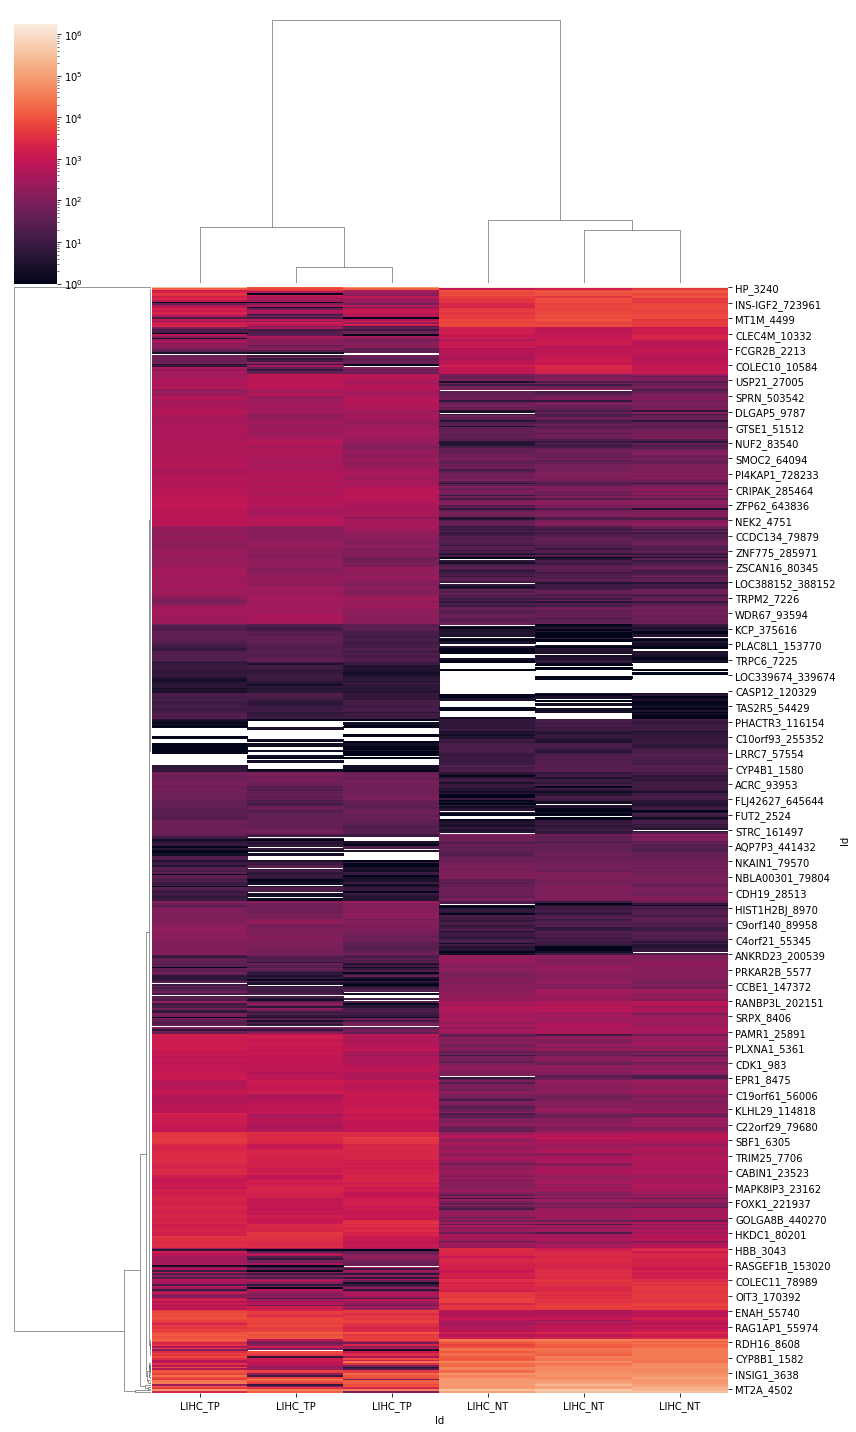

In [53]:
#@markdown Heatmap to visualize differentially expressed genes across LIHC tumor and non tumor samples
geneT = geneT.astype(float)

sns.clustermap(geneT, figsize=(12, 20), norm=LogNorm())

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f198ae04ad0>,
      dtype=object)

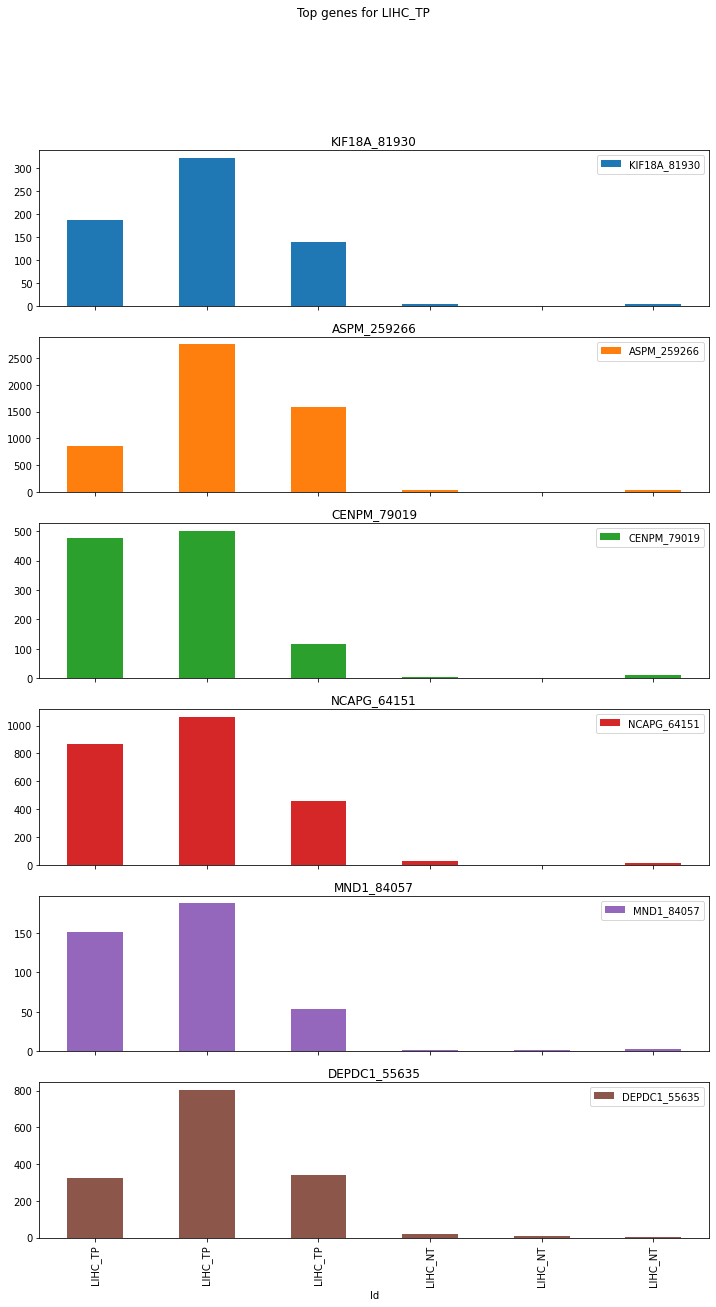

In [54]:
#@markdown Bar plots of most differently expressed genes for LIHC tumor samples
geneT.iloc[1:7,0:6].T.plot.bar(subplots=True, title="Top genes for LIHC_TP", figsize=(12, 20))

# Conclusion

---
<br>
Through exploring the initial large TCGA dataset, a subset of signficant up and down regulated genes were identified using p-values and log fold changes compared to LIHC tumor and non tumor groups. The top two most differently expressed genes were found to be KIF18A and ASPM as can be seen in the bar plot above as well as in the table in the results section. There is no current literature found in Uniprot about these genes related to LIHC, therefore there is future work to be done to have a better understanding of how these genes are implicated in LIHC and how this knowledge can be utilized for diagnosis and treatment options.